In [1]:
#%%
"""
Klasyfikuje gatunek pingwinów na podstawie ich cech fizycznych z użyciem
drzewa decyzyjnego oraz SVM, z analizą danych i porównaniem modeli.
"""

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import joblib


In [2]:
#%% 
# Wczytuje zbiór danych z pingwinami z pliku CSV.
penguins = pd.read_csv("penguins_size.csv")

# Podgląd pierwszych wierszy.
penguins.head()


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
#%% md
# EDA


In [4]:
#%%
# Definiuje funkcję zwracającą podsumowanie statystyczne i informacyjne zbioru danych.
def dataset_summary(data: pd.DataFrame) -> pd.DataFrame:
    """Zwraca tabelę podsumowującą typy danych, braki, wartości zerowe oraz statystyki opisowe dla każdej kolumny."""
    return pd.DataFrame(
        {
            "num_unique": data.nunique(),
            "num_missing": data.isnull().sum(),
            "num_inf": np.isinf(data.select_dtypes(include=[np.number])).sum(),
            "dtype": data.dtypes,
            "num_zeros": (data.select_dtypes(include=[np.number]) == 0).sum(),
            "mean": data.mean(numeric_only=True),
            "std": data.std(numeric_only=True),
            "min": data.min(numeric_only=True),
            "max": data.max(numeric_only=True),
        }
    )

dataset_summary(penguins)


,num_unique,num_missing,num_inf,dtype,num_zeros,mean,std,min,max
body_mass_g,94,2,0.0,float64,0.0,4201.754386,801.954536,2700.0,6300.0
culmen_depth_mm,80,2,0.0,float64,0.0,17.151170,1.974793,13.1,21.5
culmen_length_mm,164,2,0.0,float64,0.0,43.921930,5.459584,32.1,59.6
flipper_length_mm,55,2,0.0,float64,0.0,200.915205,14.061714,172.0,231.0
island,3,0,NaN,object,NaN,NaN,NaN,NaN,NaN
sex,3,10,NaN,object,NaN,NaN,NaN,NaN,NaN
species,3,0,NaN,object,NaN,NaN,NaN,NaN,NaN


In [5]:
#%%
# Usuwa wiersze z brakującymi wartościami, aby modele mogły działać na kompletnych danych.
penguins = penguins.dropna().reset_index(drop=True)
dataset_summary(penguins)


,num_unique,num_missing,num_inf,dtype,num_zeros,mean,std,min,max
body_mass_g,93,0,0.0,float64,0.0,4209.056886,804.836129,2700.0,6300.0
culmen_depth_mm,79,0,0.0,float64,0.0,17.160479,1.967909,13.1,21.5
culmen_length_mm,163,0,0.0,float64,0.0,43.994311,5.460521,32.1,59.6
flipper_length_mm,54,0,0.0,float64,0.0,201.014970,14.022175,172.0,231.0
island,3,0,NaN,object,NaN,NaN,NaN,NaN,NaN
sex,3,0,NaN,object,NaN,NaN,NaN,NaN,NaN
species,3,0,NaN,object,NaN,NaN,NaN,NaN,NaN


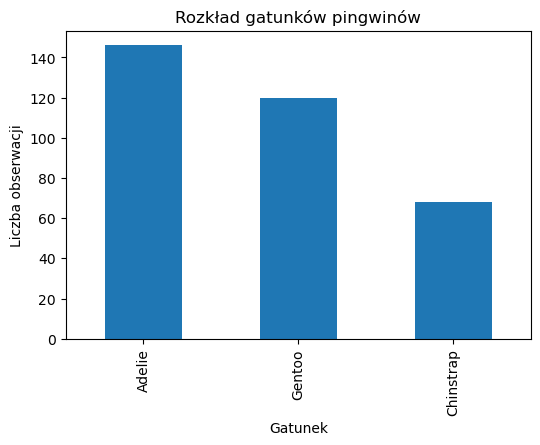

In [6]:
#%%
# Wizualizuje rozkład gatunków pingwinów.
species_counts = penguins["species"].value_counts()

plt.figure(figsize=(6, 4))
species_counts.plot(kind="bar")
plt.xlabel("Gatunek")
plt.ylabel("Liczba obserwacji")
plt.title("Rozkład gatunków pingwinów")
plt.show()


In [7]:
#%% md
# Przygotowanie danych


In [8]:
#%%
# Przygotowuje macierz cech oraz wektor etykiet gatunku pingwina.
X = penguins.drop("species", axis=1)
y = penguins["species"]

# Określa listy cech numerycznych i kategorycznych.
numeric_features = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]
categorical_features = ["island", "sex"]

# Tworzy transformację dla cech numerycznych (standaryzacja) i kategorycznych (one-hot).
numeric_transformer = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Łączy przekształcenia w jeden transformator kolumn.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Dzieli dane na zbiory treningowy i testowy z zachowaniem proporcji klas.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)


In [9]:
#%% md
# Modelowanie – SVM


In [10]:
#%%
# Buduje potok przetwarzania danych i klasyfikatora SVM.
svm_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", SVC()),
    ]
)

# Definiuje siatkę hiperparametrów SVM do przeszukania.
svm_param_grid = {
    "clf__kernel": ["rbf", "linear"],
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__class_weight": [None, "balanced"],
}

# Przeprowadza wyszukiwanie najlepszych hiperparametrów SVM metodą GridSearchCV.
svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True,
)

svm_grid.fit(X_train, y_train)

# Oblicza predykcje SVM na zbiorze testowym oraz wypisuje miary jakości.
y_pred_svm = svm_grid.predict(X_test)

print("SVM best params:", svm_grid.best_params_)
print("SVM best CV accuracy:", svm_grid.best_score_)
print("SVM test accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM classification report:\n", classification_report(y_test, y_pred_svm))
print("SVM confusion matrix:\n", confusion_matrix(y_test, y_pred_svm))


SVM best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
SVM best CV accuracy: 0.9962962962962962
SVM test accuracy: 0.9850746268656716
SVM classification report:
               precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        29
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           0.99        67
   macro avg       0.98      0.99      0.98        67
weighted avg       0.99      0.99      0.99        67

SVM confusion matrix:
 [[28  1  0]
 [ 0 14  0]
 [ 0  0 24]]


In [11]:
#%%
# Tworzy uporządkowaną tabelę z najlepszymi wynikami walidacji krzyżowej dla SVM.
svm_cv_results = (
    pd.DataFrame(svm_grid.cv_results_)
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)

print("Top 10 SVM CV results:")
svm_cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "mean_train_score",
        "param_clf__kernel",
        "param_clf__C",
        "param_clf__gamma",
        "param_clf__class_weight",
    ]
].head(10)


Top 10 SVM CV results:


,mean_test_score,std_test_score,mean_train_score,param_clf__kernel,param_clf__C,param_clf__gamma,param_clf__class_weight
0,0.996296,0.007407,0.999065,rbf,1.0,scale,balanced
1,0.996226,0.007547,0.997187,linear,0.1,auto,balanced
2,0.996226,0.007547,0.996253,rbf,1.0,scale,None
3,0.996226,0.007547,0.997187,linear,0.1,scale,balanced
4,0.996226,0.007547,0.995314,rbf,1.0,auto,None
5,0.996226,0.007547,0.998126,rbf,1.0,auto,balanced
6,0.992523,0.009158,0.995314,linear,0.1,scale,None
7,0.992523,0.009158,0.995314,linear,0.1,auto,None
8,0.992523,0.009158,0.999065,linear,10.0,scale,None
9,0.992523,0.009158,0.999065,linear,10.0,auto,None


In [12]:
#%% md
# Modelowanie – drzewo decyzyjne


In [13]:
#%%
# Buduje potok przetwarzania danych i klasyfikatora drzewa decyzyjnego.
tree_clf = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", tree_clf),
    ]
)

# Definiuje siatkę hiperparametrów drzewa decyzyjnego do przeszukania.
tree_param_grid = {
    "clf__max_depth": [None, 3, 5, 10],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__criterion": ["gini", "entropy"],
}

# Przeprowadza strojenie drzewa decyzyjnego metodą GridSearchCV.
tree_grid = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=tree_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True,
)

tree_grid.fit(X_train, y_train)

y_pred_tree = tree_grid.predict(X_test)

print("\nDecision Tree best params:", tree_grid.best_params_)
print("Decision Tree best CV accuracy:", tree_grid.best_score_)
print("Decision Tree test accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree classification report:\n", classification_report(y_test, y_pred_tree))
print("Decision Tree confusion matrix:\n", confusion_matrix(y_test, y_pred_tree))



Decision Tree best params: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Decision Tree best CV accuracy: 0.9774982529699511
Decision Tree test accuracy: 0.9701492537313433
Decision Tree classification report:
               precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.97        67
   macro avg       0.98      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67

Decision Tree confusion matrix:
 [[29  0  0]
 [ 0 14  0]
 [ 2  0 22]]


In [14]:
#%%
# Tworzy uporządkowaną tabelę z najlepszymi wynikami walidacji krzyżowej dla drzewa decyzyjnego.
tree_cv_results = (
    pd.DataFrame(tree_grid.cv_results_)
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)

print("Top 10 Decision Tree CV results:")
tree_cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "mean_train_score",
        "param_clf__max_depth",
        "param_clf__min_samples_split",
        "param_clf__min_samples_leaf",
        "param_clf__criterion",
    ]
].head(10)


Top 10 Decision Tree CV results:


,mean_test_score,std_test_score,mean_train_score,param_clf__max_depth,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__criterion
0,0.977498,0.007619,0.992510,10,2,2,entropy
1,0.977498,0.007619,0.992510,5,2,2,entropy
2,0.977498,0.007619,0.992510,None,2,2,entropy
3,0.969951,0.034966,0.995318,None,5,1,gini
4,0.969951,0.034966,0.995318,5,5,1,gini
5,0.969951,0.034966,0.995318,10,5,1,gini
6,0.966317,0.029807,1.000000,5,2,1,gini
7,0.966317,0.029807,1.000000,None,2,1,gini
8,0.966317,0.029807,1.000000,10,2,1,gini
9,0.966177,0.018460,0.990632,None,2,2,gini


In [15]:
#%% md
# Porównanie modeli


In [16]:
#%%
# Zestawia w jednej tabeli najlepsze wyniki walidacji krzyżowej oraz dokładności testowej dla SVM i drzewa decyzyjnego.
summary = pd.DataFrame(
    {
        "model": ["SVM", "Decision Tree"],
        "best_cv_accuracy": [svm_grid.best_score_, tree_grid.best_score_],
        "test_accuracy": [
            accuracy_score(y_test, y_pred_svm),
            accuracy_score(y_test, y_pred_tree),
        ],
    }
)

print("Model comparison:")
print(summary)


Model comparison:
           model  best_cv_accuracy  test_accuracy
0            SVM          0.996296       0.985075
1  Decision Tree          0.977498       0.970149


In [17]:
#%% md
# Wizualizacja macierzy pomyłek


<Figure size 500x400 with 0 Axes>

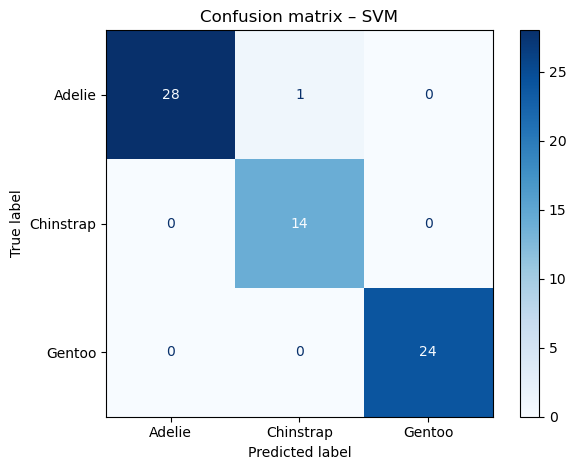

<Figure size 500x400 with 0 Axes>

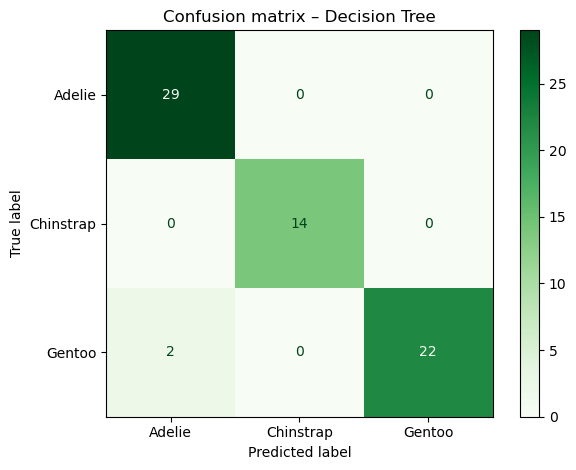

In [18]:
#%%
# Rysuje macierz pomyłek dla najlepszego modelu SVM.
classes = np.sort(y.unique())

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=classes)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=classes)
plt.figure(figsize=(5, 4))
disp_svm.plot(cmap="Blues", values_format="d")
plt.title("Confusion matrix – SVM")
plt.tight_layout()
plt.show()

# Rysuje macierz pomyłek dla najlepszego drzewa decyzyjnego.
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=classes)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=classes)
plt.figure(figsize=(5, 4))
disp_tree.plot(cmap="Greens", values_format="d")
plt.title("Confusion matrix – Decision Tree")
plt.tight_layout()
plt.show()


In [19]:
#%% md
# Zapis i testowanie modeli


In [20]:
#%%
# Zapisuje najlepsze modele SVM i drzewa decyzyjnego do plików.
joblib.dump(svm_grid.best_estimator_, "best_svm_penguins.joblib")
joblib.dump(tree_grid.best_estimator_, "best_decision_tree_penguins.joblib")

# Wczytuje modele z plików.
loaded_svm = joblib.load("best_svm_penguins.joblib")
loaded_tree = joblib.load("best_decision_tree_penguins.joblib")

# Losuje przykładowe obserwacje do demonstracji predykcji.
random_sample = X_test.sample(n=5, random_state=0)
random_true = y_test.loc[random_sample.index]

print("Random sample true labels:")
print(random_true.values)
print("SVM predictions:")
print(loaded_svm.predict(random_sample))
print("Decision Tree predictions:")
print(loaded_tree.predict(random_sample))


Random sample true labels:
['Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie']
SVM predictions:
['Adelie' 'Adelie' 'Adelie' 'Chinstrap' 'Adelie']
Decision Tree predictions:
['Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie']
